In [1]:
import sys
sys.path.insert(0, "../code/data")
sys.path.insert(0, "../code/utils")

import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm
from tqdm.notebook import trange, tqdm
from functions_markov import fillmarkov, compute_P_0, normalize_matrix, generate_chain, compute_P0_inner_loop
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
import multiprocessing
import concurrent
import time
import random


In [2]:
def plot_P0(P0stat, T, ax, scale_text=15, color=None, param_name="a"):
    xv=np.concatenate(([1], np.arange(2, P0stat.shape[0], 2)))
    x_100=np.arange(10, P0stat.shape[0], 2)
    # plot only initial value and even values to remove oscillations
    y_100=P0stat[x_100]
    
    def exp_f(x, a, b):
        return a * np.power(x, b)
    popt, pcov = curve_fit(exp_f, x_100, y_100)
    y_pred=exp_f(x_100, *popt)
    
    #model_linreg = LinearRegression()
    #model_linreg.fit(x_100, y_100)
    #y_pred=model_linreg.predict(x_100)
    #coeff=model_linreg.coef_[0][0]
    r2_score=metrics.r2_score(y_100, y_pred)
  
    if np.any(color):
        ax.plot(xv, P0stat[xv], label=f"{param_name}={T}", color=color, linewidth=2)
    else:
        ax.plot(xv, P0stat[xv], label=f"{param_name}={T}", linewidth=2)
    if isinstance(T, float): T = np.round(T, 3)
    
    ax.plot(x_100, y_pred, 'k--', label="T={0:.3}, r2={1:.3}".format(T, r2_score), linewidth=1)
    ax.legend(fontsize=scale_text)
    ax.tick_params(axis='both', which='major',labelsize=scale_text)
    try:
        ax.set_yscale('log')
        ax.set_xscale('log')
    except:
        print("not log scaled")
    
    ax.set_xlabel('∆t', fontsize=scale_text)
    ax.set_ylabel('P0(∆t)', fontsize=scale_text)
    ax.set_xlim(1, 1e4)
    ax.set_xticks([1, 10, 1e2, 1e3, 1e4])
    return popt[1]

#Relationship between T and slope
def plot_temp_vs_slope(t_range, coeffs, plot_title):
    f,a = plt.subplots(1,1)
    a.plot(t_range, coeffs, marker='o')
    a.set_xlabel("Temperature")
    a.set_ylabel("Linear slope coeff")
    a.set_title("Relationship between T and slope")
    f.savefig(plot_title, dpi=250)
    plt.show()
    
def compute_P0_multiprocess(executor, maxh, chain, tree_l):
    print("Computing P_0...")
    P0=np.zeros(maxh)
    P0stat=np.zeros(maxh)
    
    i_set = set(chain)
    futures = [executor.submit(compute_P0_inner_loop, i, P0, chain, tree_l, maxh)
               for i in i_set]
    concurrent.futures.wait(futures)
    print(f"#futures: {len(futures)}")
    for future in futures:
        res = future.result()
        P0stat = P0stat + res
        
    P0stat[0]=1
    P0stat[1]=1
    return P0stat

In [3]:
#DEF VARS
dia=0
tree_levels=[5,6,7,8,9,10]
maxh=10000 # 10000
chain_length = 1000000 # 1000000

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.15, chain_length: 1000000, Chain_maxval: 7, Pool 4
Temp 0.2, chain_length: 1000000, Chain_maxval: 7, Pool 4
Temp 0.25, chain_length: 1000000, Chain_maxval: 23, Pool 4
Temp 0.30000000000000004, chain_length: 1000000, Chain_maxval: 31, Pool 4


  0%|          | 0/32 [00:00<?, ?it/s]

P_0 computed in 11.6min
Temp 0.35000000000000003, chain_length: 1000000, Chain_maxval: 31, Pool 4


  0%|          | 0/32 [00:00<?, ?it/s]

P_0 computed in 8.38min
Temp 0.4, chain_length: 1000000, Chain_maxval: 31, Pool 4


  0%|          | 0/32 [00:00<?, ?it/s]

P_0 computed in 6.45min
Temp 0.45, chain_length: 1000000, Chain_maxval: 31, Pool 4


  0%|          | 0/32 [00:00<?, ?it/s]

P_0 computed in 5.99min


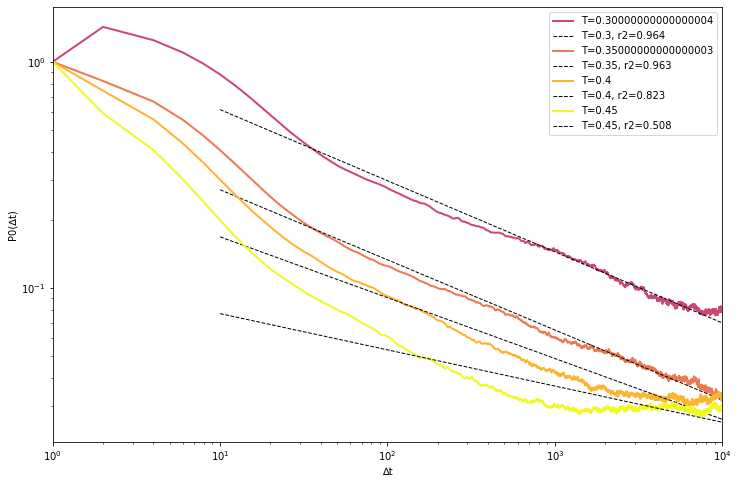

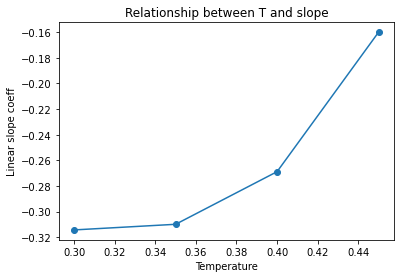

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.19999999999999998, chain_length: 1000000, Chain_maxval: 11, Pool 4
Temp 0.25, chain_length: 1000000, Chain_maxval: 15, Pool 4
Temp 0.3, chain_length: 1000000, Chain_maxval: 31, Pool 4
Temp 0.35, chain_length: 1000000, Chain_maxval: 63, Pool 4


  0%|          | 0/64 [00:00<?, ?it/s]

P_0 computed in 7.85min
Temp 0.4, chain_length: 1000000, Chain_maxval: 63, Pool 4


  0%|          | 0/64 [00:00<?, ?it/s]

P_0 computed in 4.66min
Temp 0.45000000000000007, chain_length: 1000000, Chain_maxval: 63, Pool 4


  0%|          | 0/64 [00:00<?, ?it/s]

P_0 computed in 3.49min
Temp 0.5, chain_length: 1000000, Chain_maxval: 63, Pool 4


  0%|          | 0/64 [00:00<?, ?it/s]

P_0 computed in 3.13min


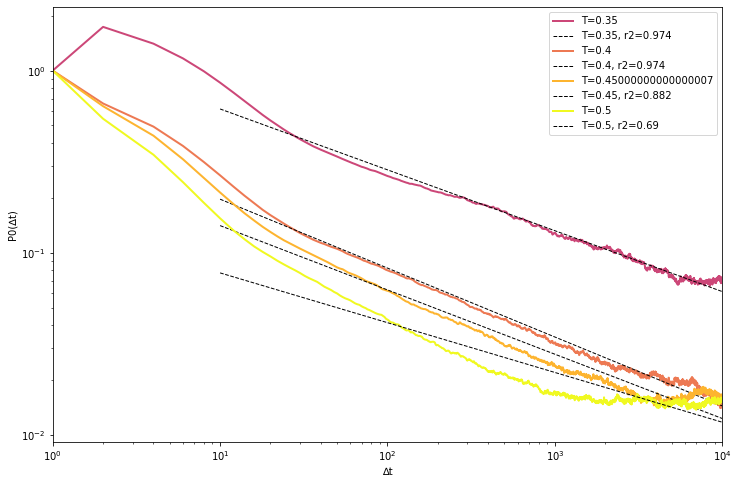

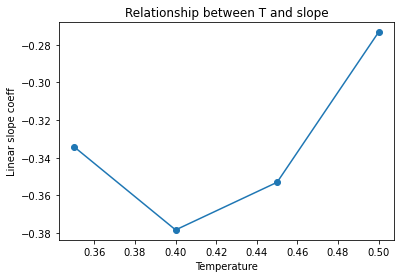

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.24999999999999997, chain_length: 1000000, Chain_maxval: 15, Pool 4
Temp 0.3, chain_length: 1000000, Chain_maxval: 63, Pool 4
Temp 0.35, chain_length: 1000000, Chain_maxval: 127, Pool 4


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed in 7.2min
Temp 0.4, chain_length: 1000000, Chain_maxval: 127, Pool 4


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed in 4.39min
Temp 0.45, chain_length: 1000000, Chain_maxval: 127, Pool 4


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed in 2.92min
Temp 0.5, chain_length: 1000000, Chain_maxval: 127, Pool 4


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed in 2.03min
Temp 0.55, chain_length: 1000000, Chain_maxval: 127, Pool 4


  0%|          | 0/128 [00:00<?, ?it/s]

P_0 computed in 1.69min


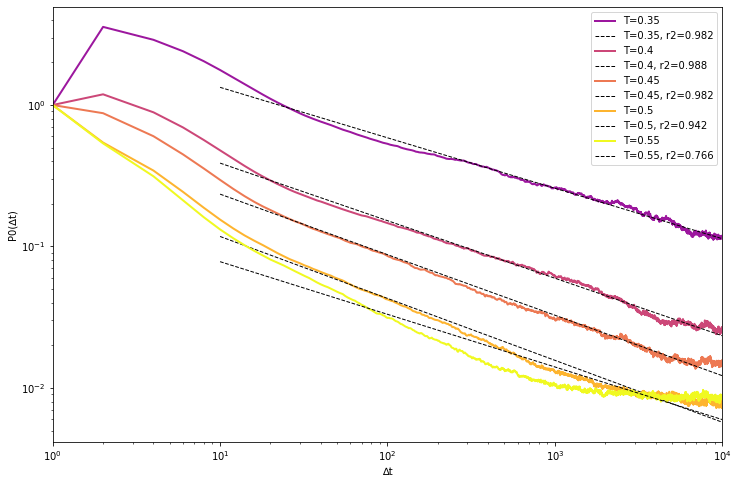

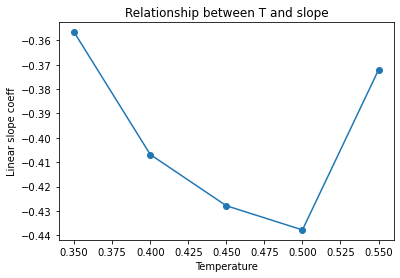

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.30000000000000004, chain_length: 1000000, Chain_maxval: 47, Pool 4
Temp 0.35000000000000003, chain_length: 1000000, Chain_maxval: 127, Pool 4
Temp 0.4000000000000001, chain_length: 1000000, Chain_maxval: 191, Pool 4
Temp 0.45000000000000007, chain_length: 1000000, Chain_maxval: 255, Pool 4


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed in 2.61min
Temp 0.5000000000000001, chain_length: 1000000, Chain_maxval: 255, Pool 4


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed in 1.57min
Temp 0.55, chain_length: 1000000, Chain_maxval: 255, Pool 4


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed in 1.07min
Temp 0.6000000000000001, chain_length: 1000000, Chain_maxval: 255, Pool 4


  0%|          | 0/256 [00:00<?, ?it/s]

P_0 computed in 0.914min


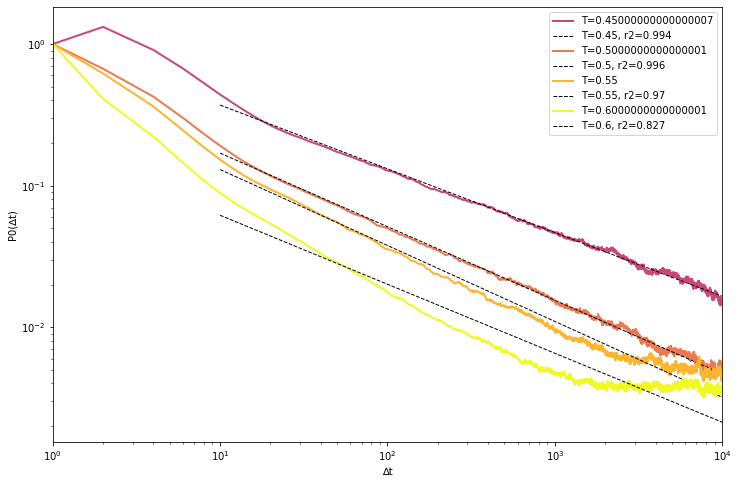

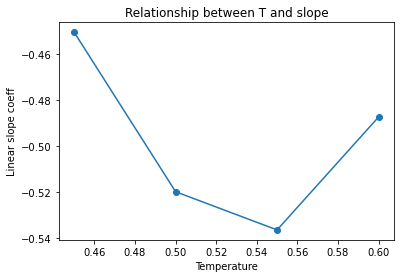

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.35, chain_length: 1000000, Chain_maxval: 95, Pool 4
Temp 0.39999999999999997, chain_length: 1000000, Chain_maxval: 223, Pool 4
Temp 0.45, chain_length: 1000000, Chain_maxval: 383, Pool 4
Temp 0.5, chain_length: 1000000, Chain_maxval: 511, Pool 4


  0%|          | 0/512 [00:00<?, ?it/s]

P_0 computed in 1.49min
Temp 0.55, chain_length: 1000000, Chain_maxval: 511, Pool 4


  0%|          | 0/512 [00:00<?, ?it/s]

P_0 computed in 0.841min
Temp 0.6000000000000001, chain_length: 1000000, Chain_maxval: 511, Pool 4


  0%|          | 0/512 [00:00<?, ?it/s]

P_0 computed in 0.571min
Temp 0.65, chain_length: 1000000, Chain_maxval: 511, Pool 4


  0%|          | 0/512 [00:00<?, ?it/s]

P_0 computed in 0.496min


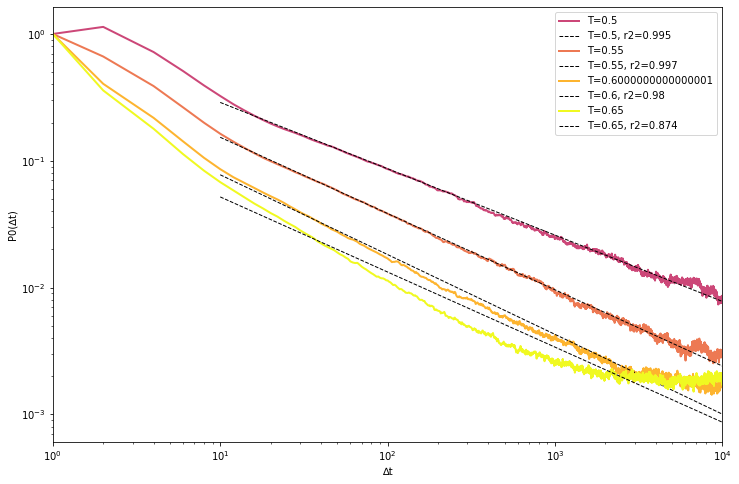

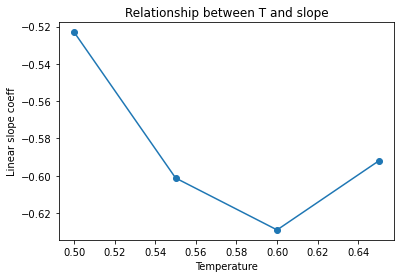

  0%|          | 0/7 [00:00<?, ?it/s]

Temp 0.4, chain_length: 1000000, Chain_maxval: 255, Pool 4
Temp 0.45, chain_length: 1000000, Chain_maxval: 511, Pool 4
Temp 0.5, chain_length: 1000000, Chain_maxval: 1023, Pool 4


  0%|          | 0/1024 [00:00<?, ?it/s]

P_0 computed in 1.4min
Temp 0.55, chain_length: 1000000, Chain_maxval: 1023, Pool 4


  0%|          | 0/1024 [00:00<?, ?it/s]

P_0 computed in 0.8min
Temp 0.6, chain_length: 1000000, Chain_maxval: 1023, Pool 4


  0%|          | 0/1024 [00:00<?, ?it/s]

P_0 computed in 0.515min
Temp 0.6499999999999999, chain_length: 1000000, Chain_maxval: 1023, Pool 4


  0%|          | 0/1024 [00:00<?, ?it/s]

P_0 computed in 0.351min
Temp 0.7, chain_length: 1000000, Chain_maxval: 1023, Pool 4


  0%|          | 0/1024 [00:00<?, ?it/s]

P_0 computed in 0.281min


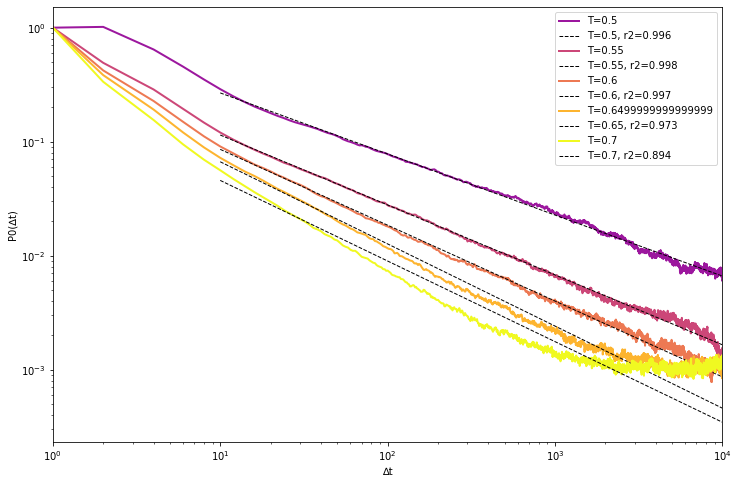

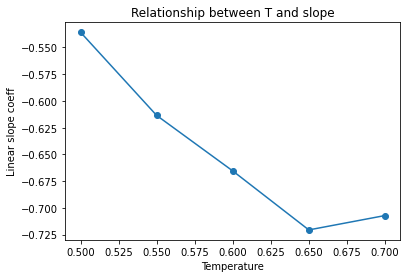

In [4]:
executor4 = concurrent.futures.ProcessPoolExecutor(4)

for tree_level in tree_levels:
    print('tree_level: ', tree_level)
    f2, a2 = plt.subplots(1,1)
    f2.set_figheight(8)
    f2.set_figwidth(12)
    tree_l=2**tree_level # number of leaves
    markovm=np.zeros((tree_l,tree_l))
    t_effective, coeffs=[], []
    
    t_range = np.linspace(tree_level/10/2-0.2, tree_level/10/2, 6)
    viridis = cm.get_cmap('plasma', len(t_range))

    for i, T in tqdm(enumerate(t_range), total=len(t_range)):
        markovm=fillmarkov(markovm,0,0,tree_l,tree_level)
        markovme=np.exp(-markovm/T)
        markovme = normalize_matrix(dia, tree_l, markovme)
        
        max_chains = []
        for repeat in range(5): #generate chains with 5 diff seeds to be sure max is reached each time
            chain = generate_chain(markovme, chain_length, verbose=0)
            max_chains.append(np.max(chain))
            
        print(f"Temp {T}, chain_length: {len(chain)}, Chain_maxval: {np.min(max_chains)}, Pool {4}")
        if np.min(max_chains) < tree_l-1: continue

        start_time = time.time()
        if len(chain) >= 1e7:
            P0stat = compute_P0_multiprocess(executor4, maxh, chain, tree_l)
        else:
            _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=0)
        end_time = time.time()
        print(f"P_0 computed in {(end_time-start_time)/60:.3}min")

        coeff=plot_P0(P0stat, T, a2, scale_text=10, color=viridis.colors[i], param_name="T")
        coeffs.append(coeff)
        t_effective.append(T)
        f2.savefig(f"../plots/temp_plot_iter_{i}_clen_{len(chain)}.jpg")
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    f2.savefig(f"../plots/plots_P0_{current_time}_depth_{tree_level}_clen_{chain_length}.jpg", dpi=200)
    plt.show()
    plot_title = f"../plots/plot_TvsSlope_{current_time}_depth_{tree_level}_clen_{chain_length}.jpg"
    plot_temp_vs_slope(t_effective, coeffs, plot_title)


# Shuffled data

In [5]:
def shuffle_blocks_v2(chain, b_len):
    shuff_chain = chain.copy() #bc we modifiy in-place afterward
    blocks = [shuff_chain[i:i+b_len] for i in range(0,len(shuff_chain),b_len)]
    np.random.shuffle(blocks)
    shuff_chain[:] = [b for bs in blocks for b in bs]
    return shuff_chain

In [6]:
tree_levels=5 # 13
maxh=10000 # 10000
chain_length = 1000000 # 10000000
tree_l=2**tree_levels # number of leaves
markovm=np.zeros((tree_l,tree_l))
T_fixed=0.4

In [7]:
chain = generate_chain(markovme, chain_length, verbose=1)

Generating Markov chain...


Computing P_0...
#futures: 1024
Block length: 10
Computing P_0...
#futures: 1024
Block length: 100
Computing P_0...
#futures: 1024
Block length: 1000
Computing P_0...
#futures: 1024


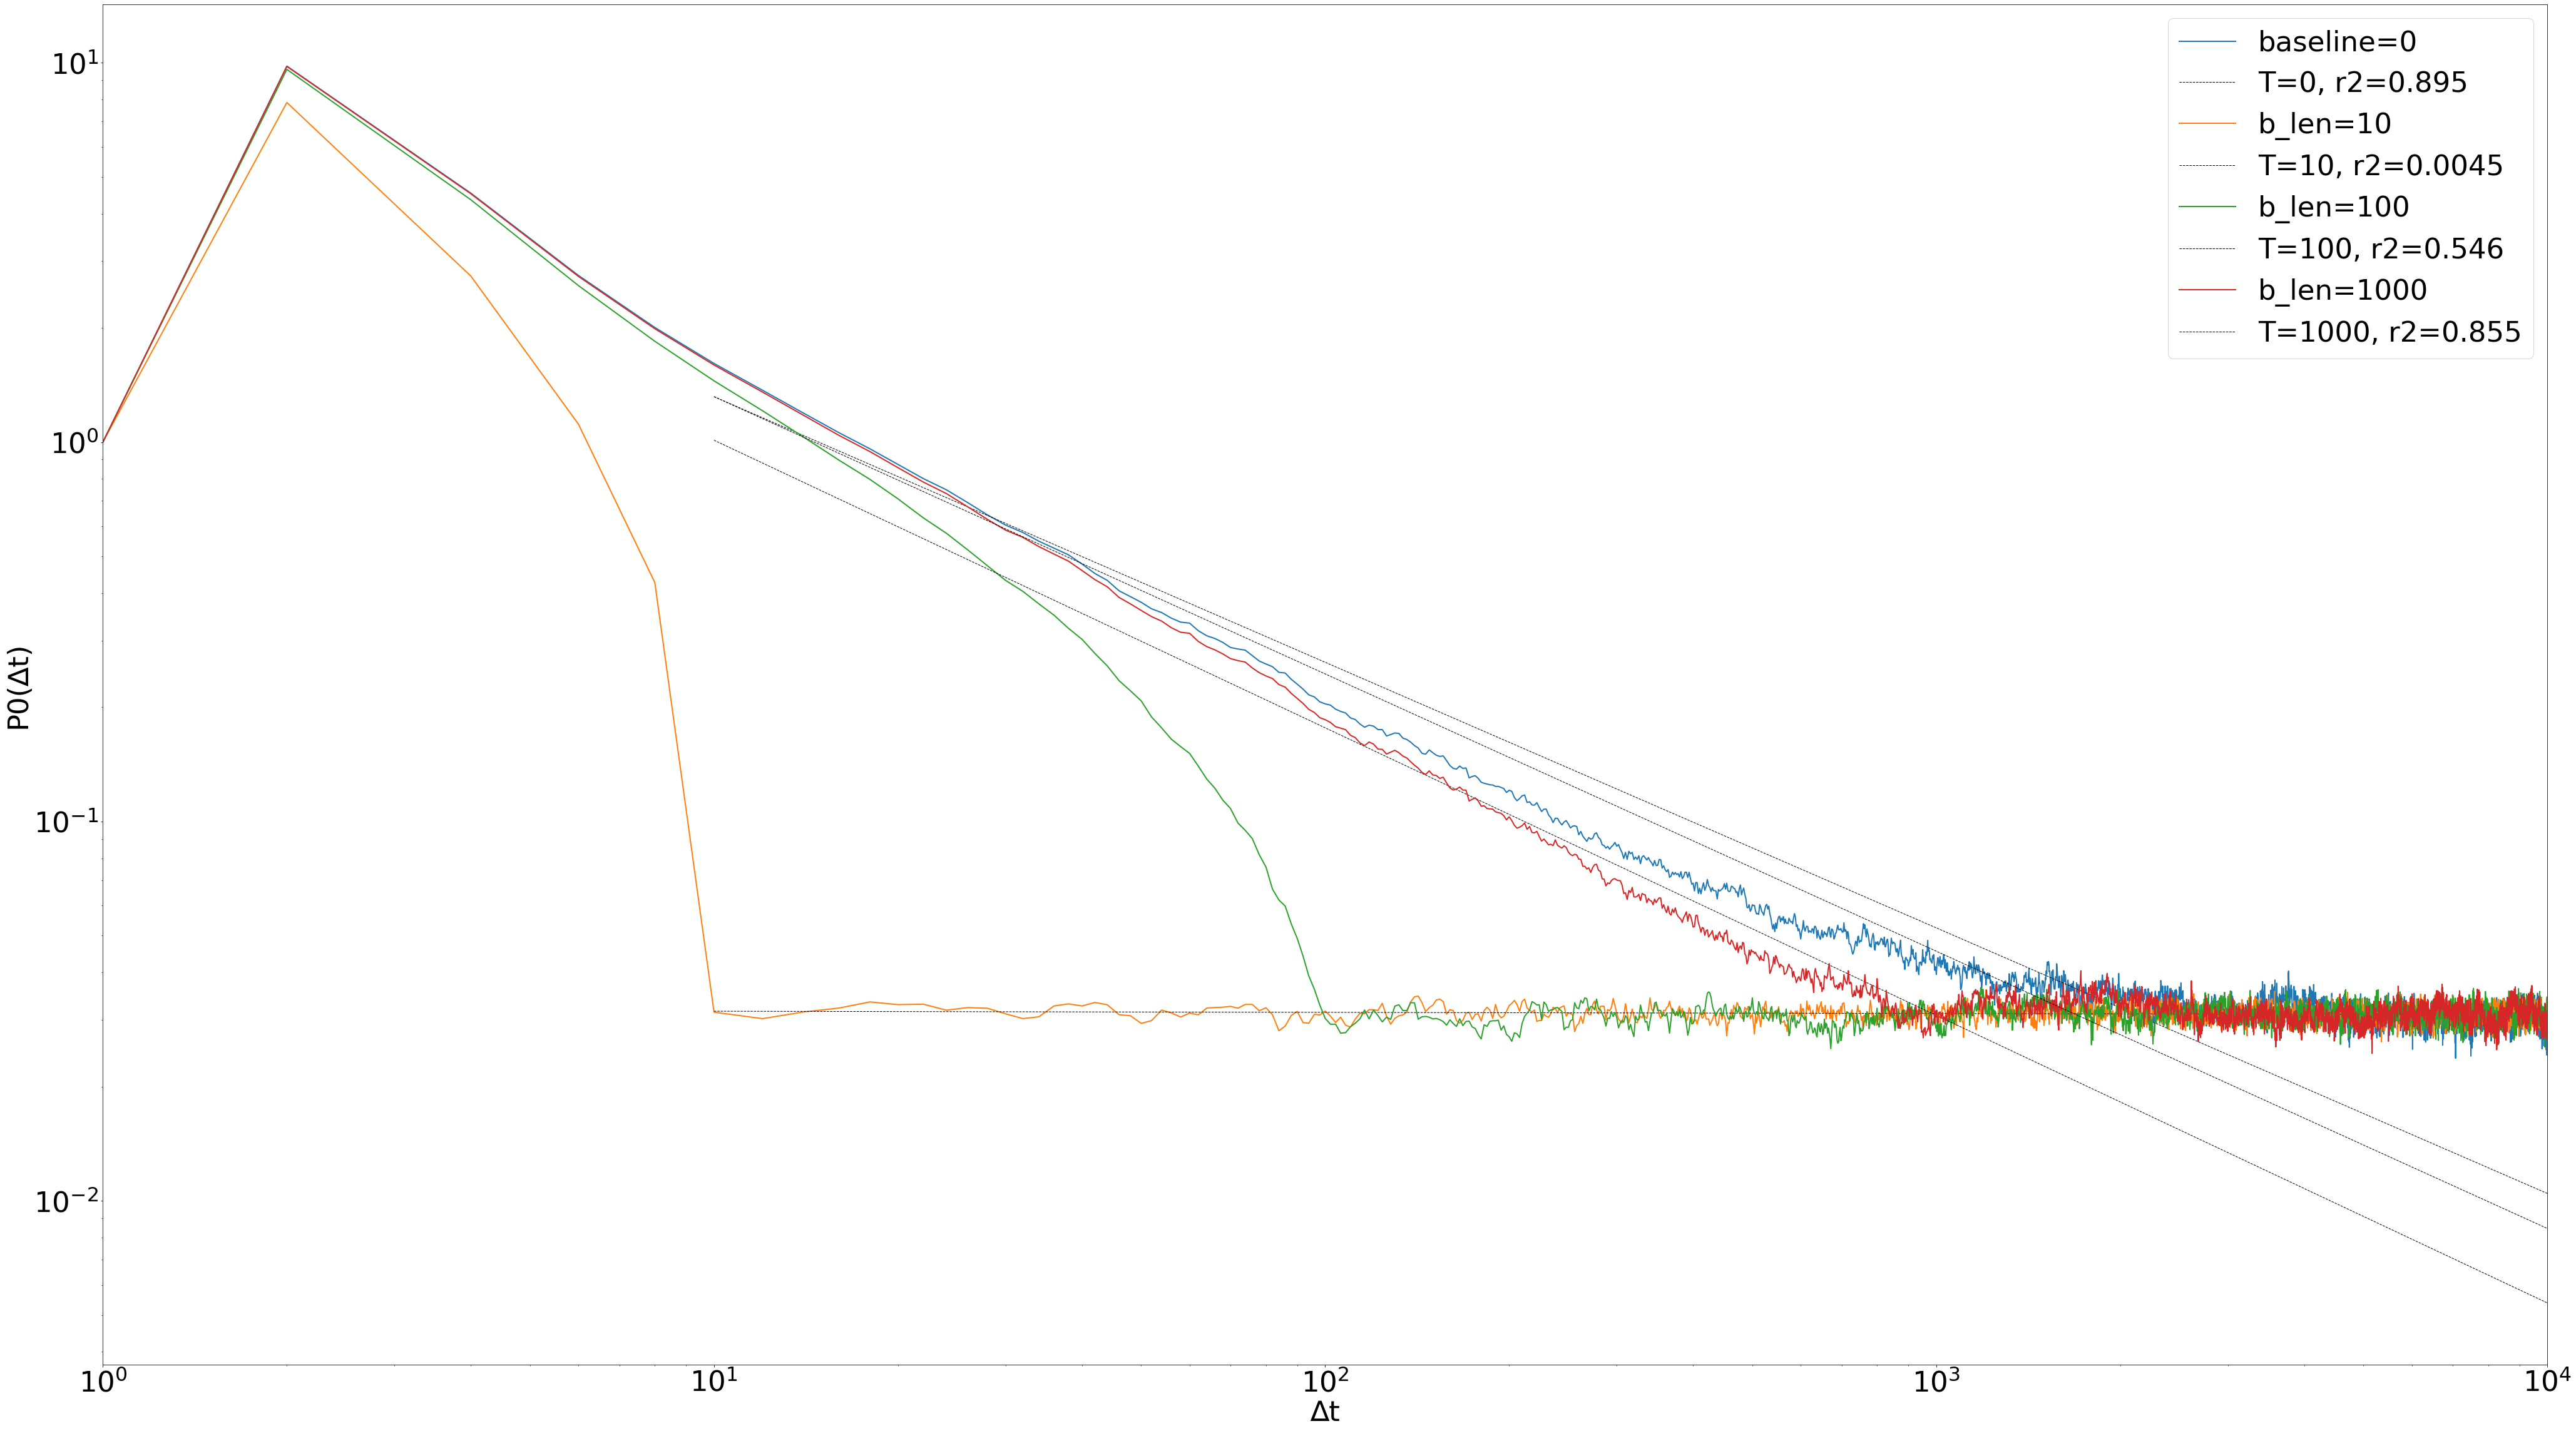

In [8]:
# shuffled data
blocklengths=[10, 100, 1000]
nbl=len(blocklengths)
f3, a3 = plt.subplots(1,1)
f3.set_figheight(40)
f3.set_figwidth(70)
executor8 = concurrent.futures.ProcessPoolExecutor(8)

#No shuffle baseline
if len(chain) >= 1e6:
    P0stat = compute_P0_multiprocess(executor8, maxh, chain, tree_l)
else:
    _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=0)
plot_P0(P0stat, 0, a3, scale_text=45, param_name="baseline")
f3.savefig(f"../plots/temp_plot_no_shuffle_depth_{tree_levels}_clen_{chain_length}.jpg")

for bl in range(0, nbl):
    blength=blocklengths[bl]
    print(f'Block length: {blength}')
    shuffled_chain=shuffle_blocks_v2(chain, blength)
    
    if len(shuffled_chain) >= 1e6:
        P0stat = compute_P0_multiprocess(executor8, maxh, shuffled_chain, tree_l)
    else:
        _, P0stat = compute_P_0(maxh, tree_l, shuffled_chain, verbose=0)    
    plot_P0(P0stat, blength, a3, scale_text=45, param_name="b_len")
    f3.savefig(f"../plots/temp_plot_shuffled_blength_{blength}.jpg")
plt.show()

# Generate sequ to save

In [55]:
#DEF VARS
dia=0
chain_length = 1000000 # 10000000
#d       5    6.  7.  8.   9.  10  
# peut etre mettre 0.43 pour d=7
T_fixed=[0.4,0.45,0.475,0.55] #,0.575,0.6]
tree_levels_list=[5,6,7,8]

In [56]:
for seed in np.arange(0, 50):
    print('seed: ', seed)
    for tree_levels, T in zip(tree_levels_list, T_fixed): # zip selected temperatures
        tree_l=2**tree_levels
        random.seed(seed)
        markovm=np.zeros((tree_l,tree_l))

        markovm=fillmarkov(markovm,0,0,tree_l,tree_levels)
        markovme=np.exp(-markovm/T)
        markovme = normalize_matrix(dia, tree_l, markovme)
        # generate the markov chain
        chain = generate_chain(markovme, chain_length, verbose=1)
        if np.max(chain) < tree_l-1:
            print(f"ERR AT: seed{seed} ,tree_levels{tree_levels}, T{T}")

        np.save(f"../data/saved_chains/tree_levels{tree_levels:02d}_clen{chain_length:.1e}_seed{seed:}", np.array(chain))

seed:  0
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  1
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  2
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  3
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  4
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  5
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  6
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  7
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
Generating Markov chain...
seed:  8
Generating Markov chain...
Generating Markov chain...
G

../data/saved_chains/tree_levels05_clen1.0e+06_seed0.npy


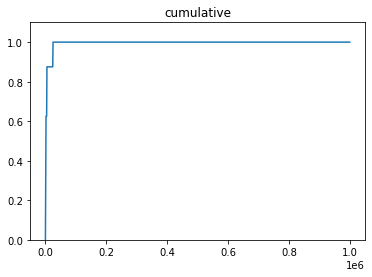

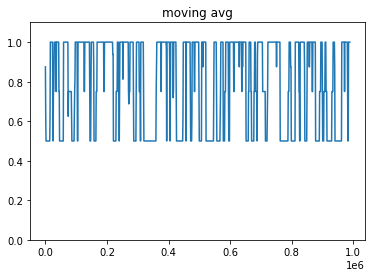

../data/saved_chains/tree_levels05_clen1.0e+06_seed1.npy


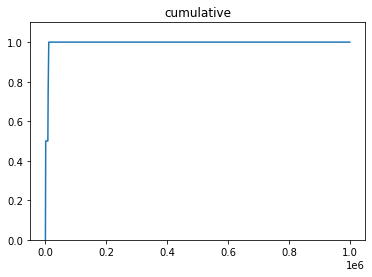

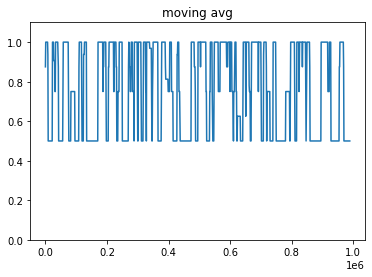

../data/saved_chains/tree_levels05_clen1.0e+06_seed2.npy


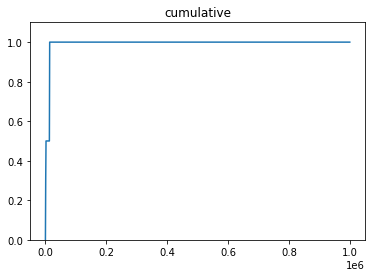

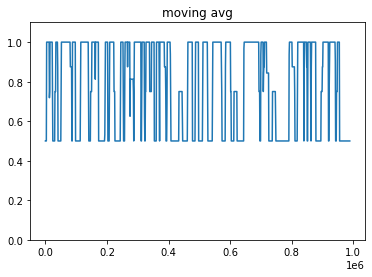

../data/saved_chains/tree_levels05_clen1.0e+06_seed3.npy


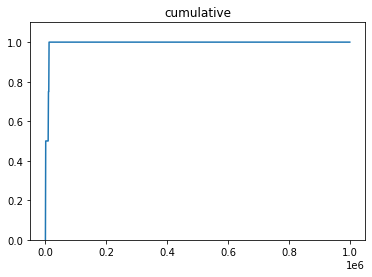

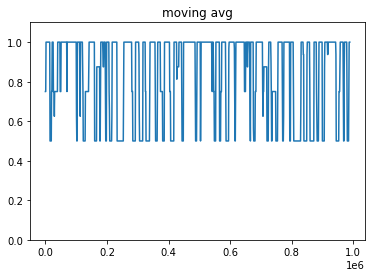

../data/saved_chains/tree_levels05_clen1.0e+06_seed4.npy


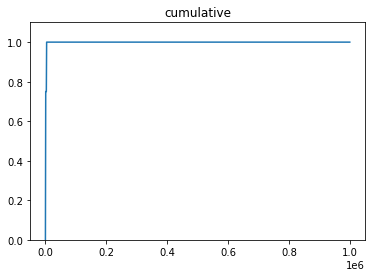

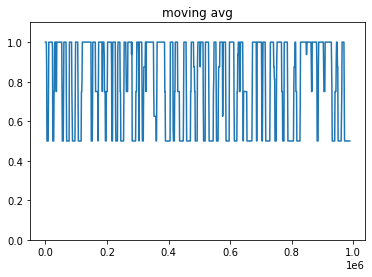

In [53]:
#Load chain from file test
from os import listdir
from os.path import isfile, join
mypath = "../data/saved_chains/"
onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles, reverse=False)
for file in onlyfiles:
    if "DS_Store" not in file:
        if 'levels05' in file and ('seed0' in file or 'seed1.' in file or 'seed2.' in file or 'seed3.' in file or 'seed4.' in file):
            print(file) 
            chain = np.load(file).tolist()
            patterns_discovered = [len(set(chain[:int(i)])) for i in np.arange(0,1e6,1000)]
            pct_patterns_discovered = np.array(patterns_discovered) / len(set(chain))
            plt.plot(np.arange(0,1e6,1000), pct_patterns_discovered)
            plt.title('cumulative')
            plt.ylim(0,1.1)
            plt.show()
            
            #moving avg
            patterns_discovered = [len(set(chain[int(i):int(i)+10000])) for i in np.arange(0,1e6-1e4,1000)]
            pct_patterns_discovered = np.array(patterns_discovered) / len(set(chain))
            plt.plot(np.arange(0,1e6-1e4,1000), pct_patterns_discovered)
            plt.title('moving avg')
            plt.ylim(0,1.1)
            plt.show()
        